# 🐶 End-to-end Multi-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cage and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data

The data we're using is from Kaggle's dog breed identification competition
https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation

The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation

## 4. Features

Som information about the data:
* We're dealing with images (unstructured data) so it's probably best we use learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10000+ images in the training set (these images have labels)
* There are around 10000+ images in the test set (these images have no labels, because we'll want to predict them)

In [1]:
# Unzip the uploaded data into Google Drive
# !unzip "drive/MyDrive/Dog Vision/dog-breed-identification.zip" -d "drive/MyDrive/Dog Vision"

Get our workspace ready
* Import TensorFlow 2.x ✅
* Import TensoeFloq Hub ✅
* Make sure we're using a GPU ✅

In [2]:
# !pip install tensorflow


In [3]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("TF hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSSS!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.11.0
TF hub version: 0.13.0
GPU available (YESSSSS!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numericalformat. So that's what we'll be doing first. Turning our images into Tensors (numerical representations)

Let's start by accessing our data and checking out the labels

In [4]:
# Checkout the labels of our data
import pandas as pd

labels_csv = pd.read_csv("drive/MyDrive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


<Axes: >

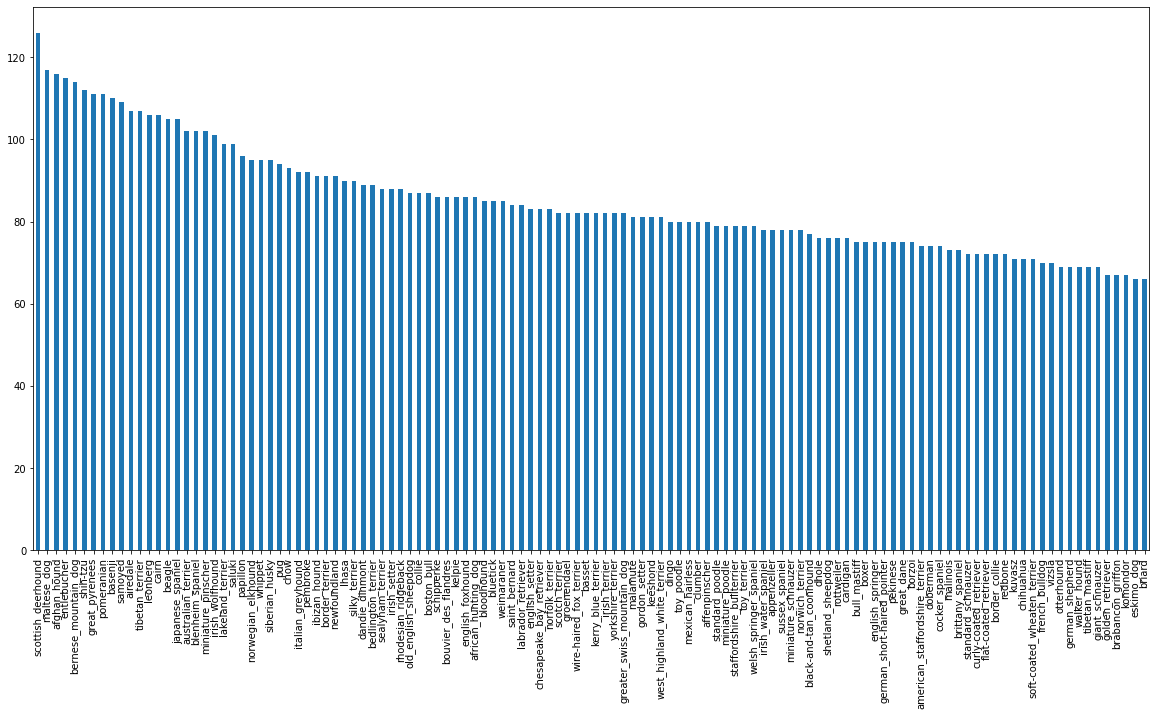

In [5]:
# How many images are there for each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [6]:
labels_csv["breed"].value_counts().median()

82.0

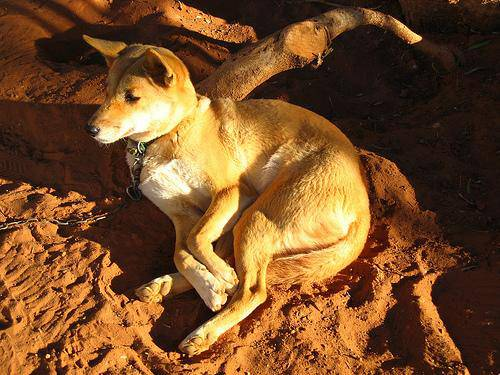

In [7]:
 # Lets view an image
 from IPython.display import Image

 Image("drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

Let's get a list of all of our image file pathnames.

In [8]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
# Create pathnames from image ID's
filenames = [f"drive/MyDrive/Dog Vision/train/{fname}.jpg" for fname in labels_csv["id"]]

# Check thge first 10
filenames[:10]

['drive/MyDrive/Dog Vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/MyDrive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/MyDrive/Dog Vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/MyDrive/Dog Vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/MyDrive/Dog Vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/MyDrive/Dog Vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/MyDrive/Dog Vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/MyDrive/Dog Vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/MyDrive/Dog Vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/MyDrive/Dog Vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [10]:
# Check whether number of filenames matches number of actual image files
from pathlib import Path

path = Path("drive/MyDrive/Dog Vision/train")
path_files = [str(x) for x in path.glob('*') if x.is_file()]

path_file_count = len(path_files)

if path_file_count == len(filenames):
  if set(filenames) == set (path_files):
    print("All files found!!!")


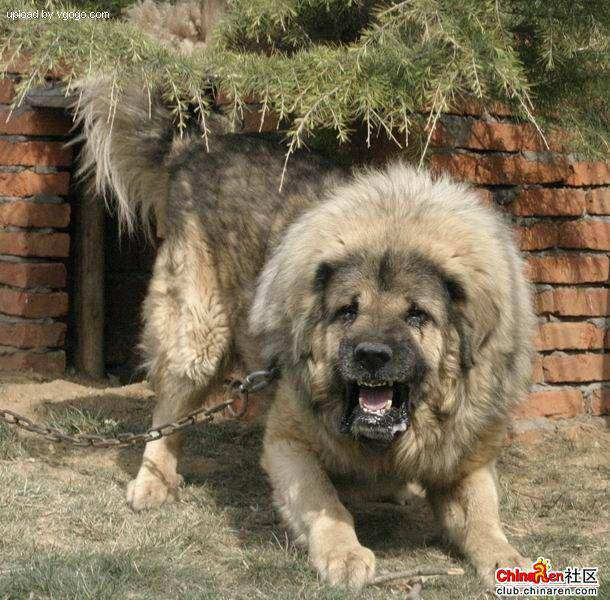

In [11]:
# One more check
Image(filenames[9000])

In [12]:
labels_csv["breed"][9000]

'tibetan_mastiff'

Since we've now got our training image filepaths in a list, lets prepare our labels.

In [13]:
import numpy as np

labels = labels_csv['breed'].to_numpy()
# labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [14]:
len(labels)

10222

In [15]:
# See if number of labels matches number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames")

Number of labels matches number of filenames


In [16]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [17]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [18]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

In [19]:
len(boolean_labels)

10222

In [20]:
# Example: Turning boolean array into integers
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where label occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # there will be a 1 where the sample occurs

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [21]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [22]:
# import a custom module to help with splitting the data sets
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

import scoring
from scoring import Tensor_Image

In [23]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [24]:
# Set number of images to sue for experimenting
NUM_IMAGES = 1000 # @param {type:"slider", min:1000, max:10000}

In [25]:
# Set the random seed
np.random.seed(42)

# Set the image size
IMG_SIZE = 224
# create the datamodel of total size NUM_IMAGES
data_model = Tensor_Image(X[:NUM_IMAGES], y[:NUM_IMAGES], img_size=IMG_SIZE)

In [26]:
# Split them into training and validation 
data_model.split_train_test(test_size=0.2)

In [27]:
len(data_model.X_train), len(data_model.y_train), len(data_model.X_valid), len(data_model.y_valid)

(800, 800, 200, 200)

In [28]:
# Lest have a geez at the training data
data_model.X_train[:5], data_model.y_train[:2]

(['drive/MyDrive/Dog Vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/MyDrive/Dog Vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/MyDrive/Dog Vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/MyDrive/Dog Vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/MyDrive/Dog Vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, 

### Preprocessing Images (turning Images into Tensors)

To preprocess our images into tensors, we are going to write a function which does a few things:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1
5. Resize the `image` to be a shape of (224, 224)
6. Return modified `image`

Before we do, lets see what importing an image looks like

In [29]:
# Convert an image to a numpy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

## Turning our data into batches

Why turn our data into batches?

Lets say youre trying to process 10000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need the data in the form of Tensor tuples which look like this:
`(image, label)`

In [30]:
(data_model.process_image(X[42]),y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, lets make a function to return all of our data (`X` & `y`) into batches

In [31]:
# Create training and validation data batches
data_model.create_data_batches(data_model.X_train, data_model.y_train)
data_model.create_data_batches(data_model.X_valid, data_model.y_valid, valid_data=True)

Creating training data batches...
Creating valid data batches...


In [32]:
# Check out the different attributes of our data batches
data_model.train.element_spec, data_model.valid.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be a little hard to understand/comprehend. Lets visualize them

In [33]:
import matplotlib.pyplot as plt

def show_n_images(unique, images, labels, n=25):
    """
    Displays a plot off 'n' images and their labels from a data batch.
    """
    # Setup the figure
    plt.figure(figsize=(10,10))
    # Loop through n (for displaying n images)
    for i in range(n):
        # Create subplots (5 rows, 5 columns)
        ax = plt.subplot(5, 5, i+1)
        # Display an image
        plt.imshow(images[i])
        # Add image label as the title
        plt.title(unique[labels[i].argmax()])
        # Turn the gridlines off
        plt.axis("off")

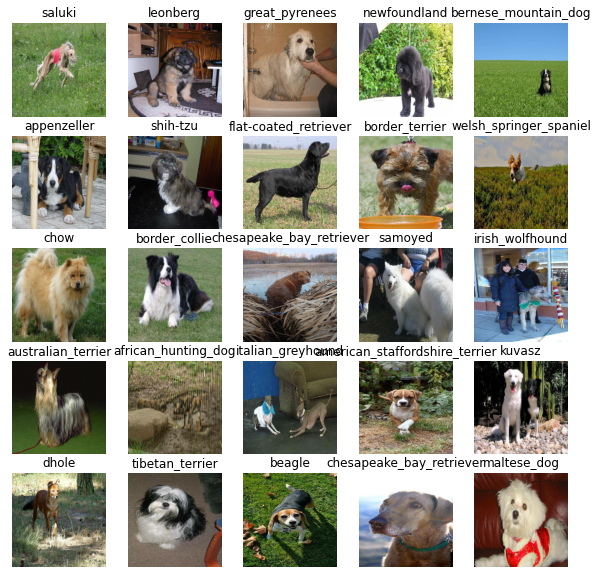

In [34]:
train_images, train_labels = next(data_model.train.as_numpy_iterator())
show_n_images(unique=unique_breeds, images=train_images, labels=train_labels)

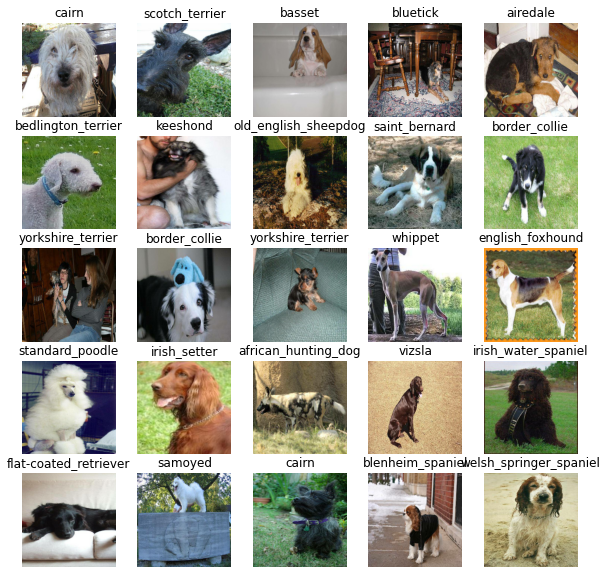

In [35]:
# Now let's visualize our validation set
val_images, val_labels = next(data_model.valid.as_numpy_iterator())
show_n_images(unique=unique_breeds, images=val_images, labels=val_labels)

## Building a model
Before we build a model, there are a few things we need to define_aliases

* The input shape (our images shape, in the form of Tensors) to our model
* The output shape (our image labels, in the form of Tensors) of our model
* The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5

In [36]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5"

Now, we've got our inputs, outputs, and model ready to go. Lets put them together into a Keras deep learning model!

Knowing this, lets create a function which:
* Takes the input shape, output shape, and the model we've chosen as parameters.
* Defines the laters in a Keras model in squential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape itll be getting).
* Returns the model.

All of these steps can be found here: https://tensorflow.org/guide/keras/overview

In [37]:
# Create a function which builds a Keras model
def create_model(input_shape, output_shape, model_url):
  print("Building model with:", model_url)
  # Setup model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(model_url),
      tf.keras.layers.Dense(units=output_shape,
                            activation="softmax")
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(input_shape)

  return model

In [38]:
model = create_model(INPUT_SHAPE, OUTPUT_SHAPE, MODEL_URL)
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              6158505   
                                                                 
 dense (Dense)               (None, 120)               120240    
                                                                 
Total params: 6,278,745
Trainable params: 120,240
Non-trainable params: 6,158,505
_________________________________________________________________


In [39]:
model = data_model.create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL)
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              6158505   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 6,278,745
Trainable params: 120,240
Non-trainable params: 6,158,505
_________________________________________________________________


In [40]:
outputs = np.ones(shape=(1,1,1280))